In [1]:
import os
os.chdir("../../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import catboost as cb
from scr.util import *

In [131]:
df = pd.read_csv('data/feature_engineered/null_del_xxx/train_null_del.csv')
df_submit = pd.read_csv('data/feature_engineered/null_cat_cat/test_null_cat_cat.csv')

### 欠損値を扱う場合

In [124]:
df_submit_null = pd.read_csv('data/test.csv')

age_null_id = df_submit_null.loc[df_submit_null['Age'].isna(), 'id'].values
duration_null_id = df_submit_null.loc[df_submit_null['DurationOfPitch'].isna(), 'id'].values
trips_null_id = df_submit_null.loc[df_submit_null['NumberOfTrips'].isna(), 'id'].values
income_null_id = df_submit_null.loc[df_submit_null['MonthlyIncome'].isna(), 'id'].values

for id in age_null_id:
    df_submit.loc[df_submit['id'] == id, 'Age'] = np.nan

for id in duration_null_id:
    df_submit.loc[df_submit['id'] == id, 'DurationOfPitch'] = np.nan

for id in trips_null_id:
    df_submit.loc[df_submit['id'] == id, 'NumberOfTrips'] = np.nan

for id in income_null_id:
    df_submit.loc[df_submit['id'] == id, 'MonthlyIncome'] = np.nan

# Catboost

In [132]:
# 特徴量選択
feature = [
    'Age',
    'TypeofContact',
    'CityTier',
    'DurationOfPitch',
    'Occupation',
    'Gender',
    'NumberOfPersonVisiting',
    'NumberOfFollowups',
    'ProductPitched',
    'PreferredPropertyStar',
    'NumberOfTrips',
    'Passport',
    'PitchSatisfactionScore',
    'Designation',
    'MonthlyIncome',
    'Marry',
    'Car',
    'Child',
    # 以下、作成特徴量
    #'AgeGroup',
    ##'TypeofContactNULL',
    ##'Motivation',
    #'EconomicPower',
    ##'Child01',
    'TripEasier',
    ##'SalesPerformance',
    #'LivingCost',
    #'EconomicStability',
    # 'TripFreaqency',
    #'TravelCost',
    #'NumberOfTrips_log',
    #'EconomicSegment',
    #'PackageMatch'
]

# catboostでカテゴリ変数を指定するためのリスト
category_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 
                'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Marry', 'Car', 'Child']# + ['EconomicSegment']


df = mapping_columns_if_exist(df)
df_submit = mapping_columns_if_exist(df_submit)

X = df[feature]
y = df['ProdTaken']
df_submit = df_submit[feature]

In [23]:
display(X.iloc[:5, 18:])
display(df_submit.iloc[:5, 18:])

,AgeGroup
0,5
1,5
2,3
3,4
4,1


,AgeGroup
0,4
1,3
2,2
3,2
4,4


In [133]:
# 学習モデル Regressor

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'iterations': 10000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 5,  # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7201016	best: 0.7201016 (0)	total: 4.37ms	remaining: 43.7s
100:	test: 0.7885305	best: 0.7891278 (56)	total: 159ms	remaining: 15.6s
200:	test: 0.7901235	best: 0.7901235 (200)	total: 282ms	remaining: 13.8s
300:	test: 0.7929510	best: 0.7929908 (299)	total: 411ms	remaining: 13.2s
400:	test: 0.7967941	best: 0.7970131 (397)	total: 551ms	remaining: 13.2s
500:	test: 0.8012346	best: 0.8012346 (500)	total: 680ms	remaining: 12.9s
600:	test: 0.8051971	best: 0.8053963 (595)	total: 816ms	remaining: 12.8s
700:	test: 0.8087614	best: 0.8087614 (700)	total: 952ms	remaining: 12.6s
800:	test: 0.8116288	best: 0.8116886 (798)	total: 1.1s	remaining: 12.7s
900:	test: 0.8126045	best: 0.8128236 (896)	total: 1.25s	remaining: 12.6s
1000:	test: 0.8146157	best: 0.8148347 (995)	total: 1.4s	remaining: 12.6s
1100:	test: 0.8153724	best: 0.8154719 (1094)	total: 1.54s	remaining: 12.4s
1200:	test: 0.8167861	best: 0.8168459 (1180)	total: 1.67s	remaining: 12.2s
1300:	test: 0.8166268	best: 0.8169255 (1238)	total: 

In [16]:
# モデルを保存
# ベストモデルを保存中
# 学習データセットについて、意味がある欠損値2つ以外を削除した学習データセット。

# for i, model in enumerate(models):
#     with open ('model/catboost/catboost_model_{}.pkl'.format(i), 'wb') as f:
#         pickle.dump(model, f)

     feature_importance             column  fold
0              7.975221                Age     1
1              1.800329      TypeofContact     1
2              1.305095           CityTier     1
3              4.427451    DurationOfPitch     1
4              1.421385         Occupation     1
..                  ...                ...   ...
150            3.929832  EconomicStability     5
151            2.615736         TravelCost     5
152            1.965438  NumberOfTrips_log     5
153            2.660267    EconomicSegment     5
154            0.772183       PackageMatch     5

[155 rows x 3 columns]


C:\Users\ricke\AppData\Local\Temp\ipykernel_2288\4245149276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_importance_df,


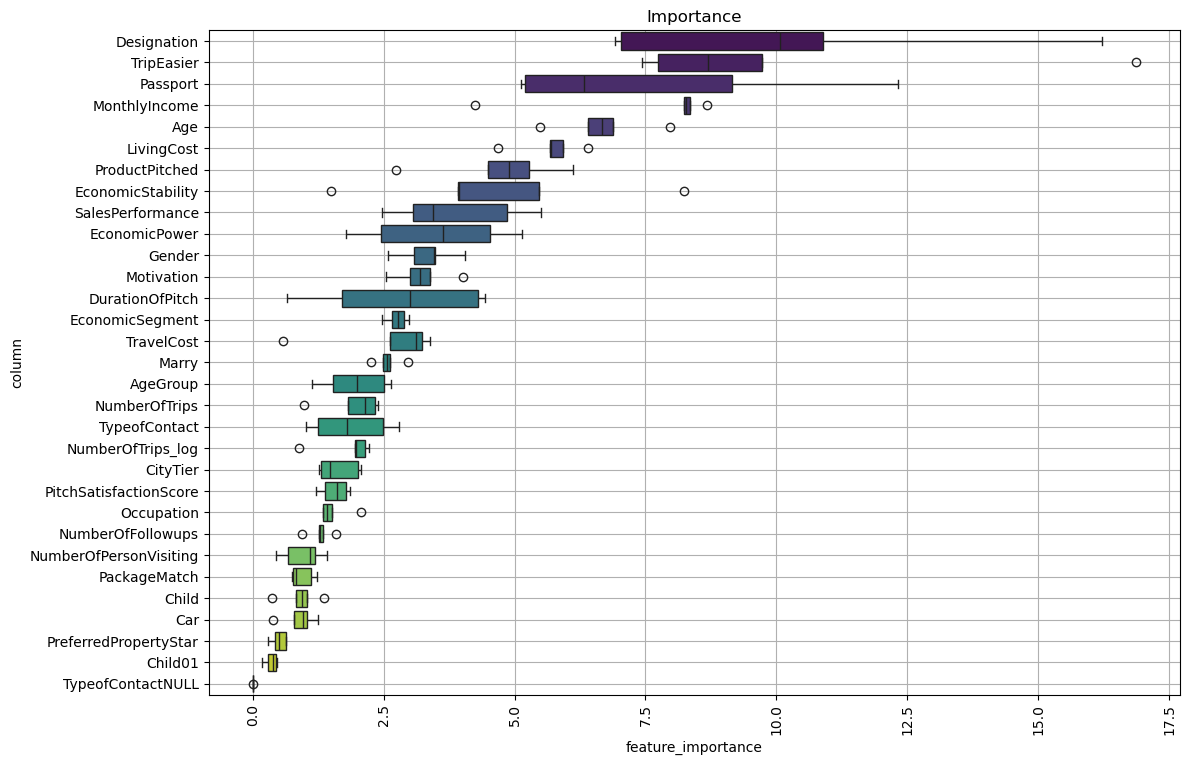

In [15]:
# 特徴量の重要度

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                        axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    print(feature_importance_df)
    #feature_importance_df_drop_speed = feature_importance_df[feature_importance_df["column"] != "speed"]
    sns.boxplot(data=feature_importance_df,
                x="feature_importance",
                y="column",
                order=order,
                ax=ax,
                palette="viridis",
                orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, X)

# Classifier

In [16]:
# 学習モデル Classifier

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostClassifier(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict_proba(va_x)[:, 1]
        models.append(model)
    return oof_pred, models

params = {
    'scale_pos_weight': 497/2992,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 8000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 7,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.6006940	best: 0.6006940 (0)	total: 3.64ms	remaining: 29.1s
100:	test: 0.8277926	best: 0.8299164 (88)	total: 236ms	remaining: 18.5s
200:	test: 0.8370234	best: 0.8370234 (200)	total: 452ms	remaining: 17.5s
300:	test: 0.8413545	best: 0.8414214 (299)	total: 668ms	remaining: 17.1s
400:	test: 0.8416221	best: 0.8427592 (342)	total: 883ms	remaining: 16.7s
500:	test: 0.8424582	best: 0.8427926 (438)	total: 1.1s	remaining: 16.5s
600:	test: 0.8411037	best: 0.8427926 (438)	total: 1.32s	remaining: 16.3s
700:	test: 0.8399164	best: 0.8427926 (438)	total: 1.54s	remaining: 16s
800:	test: 0.8397157	best: 0.8427926 (438)	total: 1.75s	remaining: 15.7s
900:	test: 0.8399666	best: 0.8427926 (438)	total: 1.96s	remaining: 15.4s
1000:	test: 0.8402007	best: 0.8427926 (438)	total: 2.17s	remaining: 15.1s
1100:	test: 0.8403010	best: 0.8427926 (438)	total: 2.38s	remaining: 14.9s
1200:	test: 0.8403177	best: 0.8427926 (438)	total: 2.59s	remaining: 14.6s
1300:	test: 0.8403344	best: 0.8427926 (438)	total: 2.81

# 提出

In [94]:
# for col in category_columns:
#     df_submit[col] = df_submit[col].astype('str')

y_submit = np.zeros(len(df_submit))
for model in models:
    y_submit += model.predict(df_submit) / len(models)

index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.066184
1,3490,0.213647
2,3491,0.335578
3,3492,0.440322
4,3493,0.260274


In [95]:
path = 'submission/submit_22_欠損値として予測した.csv'

In [96]:
df_submit.to_csv(path, index=False, header=None)

# シード値アンサンブル

In [126]:
def catboost_seed_ensemble(seed):
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_list = list(skf.split(X, y))

    def train_catboost(X, y, cv, params: dict = None):
        if params is None:
            params = {}

        models = []
        n_records = len(X)
        oof_pred = np.zeros((n_records, ))
        for i, (tr_idx, va_idx) in enumerate(cv):
            tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
            tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
            model = cb.CatBoostRegressor(**params)
            model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
            oof_pred[va_idx] = model.predict(va_x)
            models.append(model)
        return oof_pred, models

    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'AUC',
        'iterations': 9000,
        'learning_rate': 0.005,
        'depth': 5,
        # 'cat_features': category_columns,
        'l2_leaf_reg': 5,  # 3 ~ 10
        'verbose': 200,
        'random_seed': 42,
    }

    oof, models = train_catboost(X, y, cv_list, params)

    y_submit = np.zeros(len(df_submit))
    for model in models:
        y_submit += model.predict(df_submit) / len(models)
    
    return y_submit

In [127]:
# 1モデル1分46秒
seed = np.arange(50)
y_submit_list = []

for seed in seed:
    y_submit = catboost_seed_ensemble(seed)
    y_submit_list.append(y_submit)

y_submit = np.sum(y_submit_list, axis=0) / len(y_submit_list)
print(y_submit)

0:	test: 0.8001294	best: 0.8001294 (0)	total: 10.3ms	remaining: 1m 32s
100:	test: 0.8267224	best: 0.8282557 (35)	total: 162ms	remaining: 14.3s
200:	test: 0.8281561	best: 0.8282955 (182)	total: 276ms	remaining: 12.1s
300:	test: 0.8272601	best: 0.8282955 (182)	total: 390ms	remaining: 11.3s
400:	test: 0.8278973	best: 0.8283951 (367)	total: 499ms	remaining: 10.7s
500:	test: 0.8276185	best: 0.8288331 (481)	total: 608ms	remaining: 10.3s
600:	test: 0.8281760	best: 0.8288331 (481)	total: 723ms	remaining: 10.1s
700:	test: 0.8281561	best: 0.8288331 (481)	total: 837ms	remaining: 9.91s
800:	test: 0.8284349	best: 0.8288331 (481)	total: 969ms	remaining: 9.92s
900:	test: 0.8275587	best: 0.8288331 (481)	total: 1.08s	remaining: 9.72s
1000:	test: 0.8274194	best: 0.8288331 (481)	total: 1.2s	remaining: 9.59s
1100:	test: 0.8268618	best: 0.8288331 (481)	total: 1.32s	remaining: 9.45s
1200:	test: 0.8264237	best: 0.8288331 (481)	total: 1.44s	remaining: 9.33s
1300:	test: 0.8255078	best: 0.8288331 (481)	total: 1

In [128]:
index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.067197
1,3490,0.216530
2,3491,0.334484
3,3492,0.412721
4,3493,0.338511


In [129]:
path = 'submission/submit_23_シード値アンサンブル.csv'

In [130]:
df_submit.to_csv(path, index=False, header=None)